## Challenge

Now take your Keras skills and go build another neural network. Pick your data set, but it should be one of abstract types, possibly even nonnumeric, and use Keras to make five implementations of your network. Compare them both in computational complexity as well as in accuracy and given that tradeoff decide which one you like best.

Your dataset should be sufficiently large for a neural network to perform well (samples should really be in the thousands here) and try to pick something that takes advantage of neural networks’ ability to have both feature extraction and supervised capabilities, so don’t pick something with an easy to consume list of features already generated for you (though neural networks can still be useful in those contexts).

Note that if you want to use an unprocessed image dataset, scikit-image is a useful package for converting to importable numerics.

We'll use a dataset containing images os 81 different fruits and implement keras to predict fruit types. The dataset is available in the link below.
https://www.kaggle.com/moltean/fruits

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import tensorflow as tf
import keras 

# Import various componenets for model building
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import LSTM, Input, TimeDistributed
from keras.models import Model
from keras.optimizers import RMSprop

import os
import cv2
import glob

# Import the backend
from keras import backend as K

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


The training and tests are already available in separate folders. 

In [2]:
#Importing the training set
train_fruit_img = []
train_labels = [] 
for fruit_path in glob.glob("../Omistaja/*/fruits-360/Training/*"):
    fruit_label = fruit_path.split("\\")[-1]
    for image_path in glob.glob(os.path.join(fruit_path, "*.jpg")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        # Shrink
        image = cv2.resize(image, (50, 50))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        train_fruit_img.append(image)
        train_labels.append(fruit_label)
train_fruit_img = np.array(train_fruit_img)
train_labels = np.array(train_labels)

In [3]:
#Inspect labels
train_labels

array(['Apple Braeburn', 'Apple Braeburn', 'Apple Braeburn', ...,
       'Walnut', 'Walnut', 'Walnut'], dtype='<U19')

In [4]:
fruit_path

'../Omistaja\\fruits\\fruits-360\\Training\\Walnut'

In [5]:
#Importing the test set
test_fruit_img = []
test_labels = [] 
for fruit_path in glob.glob("../Omistaja/*/fruits-360/Test/*"):
    fruit_label = fruit_path.split("\\")[-1]
    for image_path in glob.glob(os.path.join(fruit_path, "*.jpg")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        image = cv2.resize(image, (50, 50))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        test_fruit_img.append(image)
        test_labels.append(fruit_label)
test_fruit_img = np.array(test_fruit_img)
test_labels = np.array(test_labels)

In [6]:
# create labels dictionary 
label_to_id = {v: i for i,v in enumerate(np.unique(train_labels))}
id_to_label = {v: k for k, v in label_to_id.items()}

In [7]:
# 81 of fruit types
id_to_label

{0: 'Apple Braeburn',
 1: 'Apple Golden 1',
 2: 'Apple Golden 2',
 3: 'Apple Golden 3',
 4: 'Apple Granny Smith',
 5: 'Apple Red 1',
 6: 'Apple Red 2',
 7: 'Apple Red 3',
 8: 'Apple Red Delicious',
 9: 'Apple Red Yellow',
 10: 'Apricot',
 11: 'Avocado',
 12: 'Avocado ripe',
 13: 'Banana',
 14: 'Banana Red',
 15: 'Cactus fruit',
 16: 'Cantaloupe 1',
 17: 'Cantaloupe 2',
 18: 'Carambula',
 19: 'Cherry 1',
 20: 'Cherry 2',
 21: 'Cherry Rainier',
 22: 'Cherry Wax Black',
 23: 'Cherry Wax Red',
 24: 'Cherry Wax Yellow',
 25: 'Clementine',
 26: 'Cocos',
 27: 'Dates',
 28: 'Granadilla',
 29: 'Grape Pink',
 30: 'Grape White',
 31: 'Grape White 2',
 32: 'Grapefruit Pink',
 33: 'Grapefruit White',
 34: 'Guava',
 35: 'Huckleberry',
 36: 'Kaki',
 37: 'Kiwi',
 38: 'Kumquats',
 39: 'Lemon',
 40: 'Lemon Meyer',
 41: 'Limes',
 42: 'Lychee',
 43: 'Mandarine',
 44: 'Mango',
 45: 'Maracuja',
 46: 'Melon Piel de Sapo',
 47: 'Mulberry',
 48: 'Nectarine',
 49: 'Orange',
 50: 'Papaya',
 51: 'Passion Fruit',


In [8]:
train_labels_id = np.array([label_to_id[i] for i in train_labels])
test_labels_id = np.array([label_to_id[i] for i in test_labels])
test_labels_id


array([ 0,  0,  0, ..., 80, 80, 80])

In [11]:
# Normalize values to 1 from 0 to 255 (256 values of pixels)
train_fruit_img, test_fruit_img = train_fruit_img / 255.0, test_fruit_img / 255.0 


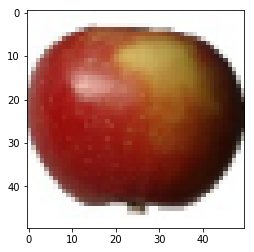

In [12]:
# show sample image
plt.imshow(train_fruit_img[100])

In [25]:
# Assigning train and test
X_train, X_test = train_fruit_img, test_fruit_img
y_train, y_test = train_labels_id, test_labels_id

In [14]:
# Convert to float32 for type consistency
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [28]:
#Reshaping to flattened arrays
X_train_flat = X_train.reshape(X_train.shape[0], 50*50*3)
X_test_flat = X_test.reshape(X_test.shape[0], 50*50*3)

# Convert class vectors to binary class matrices
# create 81 binary columns ofr each label
y_train = keras.utils.to_categorical(y_train, 81, dtype='float')
y_test = keras.utils.to_categorical(y_test, 81, dtype='float')

print('Original Sizes:', X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print('Flattened:', X_train_flat.shape, X_test_flat.shape)

Original Sizes: (41322, 50, 50, 3) (13877, 50, 50, 3) (41322, 81) (13877, 81)
Flattened: (41322, 7500) (13877, 7500)


## Multi Layer Perceptron

We'll use a sequential model using layers of 128 and 64 nodes respectively with a Rectified Linear Unit activation funcion and a dropout of 0.1

In [29]:
# Start with a simple sequential model
model = Sequential()

# Add dense layers to create a fully connected MLP
# Note that we specify an input shape for the first layer, but only the first layer.
# Relu is the activation function used
model.add(Dense(128, activation='relu', input_shape=(X_train_flat.shape[1],)))
# Dropout layers remove features and fight overfitting
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
# End with a number of units equal to the number of classes we have for our outcome
model.add(Dense(81, activation='softmax'))

model.summary()

# Compile the model to put it all together.
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])


history = model.fit(X_train_flat, y_train,
                    batch_size=128,
                    epochs=10,
                    verbose=1,
                    validation_data=(X_test_flat, y_test))
score = model.evaluate(X_test_flat, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               960128    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 81)                5265      
Total params: 973,649
Trainable params: 973,649
Non-trainable params: 0
_________________________________________________________________
Train on 41322 samples, validate on 13877 samples
Epoch 1/10
41322/41322 [==============================] - 25s 611us/step - loss: 3.188

Let's modify the model by adding more dense layers.Each layer will have: 256, 256, 128, and 64, nodes respectively. We'll still use the Rectified Linear Unit activation funcion.

## Multi Layer Perceptron with dense layers

In [30]:
# Start with a simple sequential model
model = Sequential()

# Add dense layers to create a fully connected MLP
# Note that we specify an input shape for the first layer, but only the first layer.
# Relu is the activation function used
model.add(Dense(256, activation='relu', input_shape=(X_train_flat.shape[1],)))
# Dropout layers remove features and fight overfitting
model.add(Dropout(0.1))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
# End with a number of units equal to the number of classes we have for our outcome
model.add(Dense(81, activation='softmax'))

model.summary()

# Compile the model to put it all together.
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])


history = model.fit(X_train_flat, y_train,
                    batch_size=128,
                    epochs=10,
                    verbose=1,
                    validation_data=(X_test_flat, y_test))
score = model.evaluate(X_test_flat, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               1920256   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
__________

We've managed to increase the accuracy by adding more layers with more nodes. Now let's use Convolutional Neural Networks and try to increse the accuracy. 

## Convolutional Neural Networks

We'll build a Convolutional Neural Network. 

In [36]:
# Building the Model
num_classes = 81
model = Sequential()
# First convolutional layer, note the specification of shape
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(50, 50, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(X_train, y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 41322 samples, validate on 13877 samples
Epoch 1/10
41322/41322 [==============================] - 447s 11ms/step - loss: 3.2145 - acc: 0.1949 - val_loss: 1.0897 - val_acc: 0.6889
Epoch 2/10
41322/41322 [==============================] - 431s 10ms/step - loss: 1.0717 - acc: 0.6567 - val_loss: 0.3127 - val_acc: 0.8970
Epoch 3/10
41322/41322 [==============================] - 424s 10ms/step - loss: 0.5167 - acc: 0.8231 - val_loss: 0.2411 - val_acc: 0.9199
Epoch 4/10
41322/41322 [==============================] - 420s 10ms/step - loss: 0.3511 - acc: 0.8777 - val_loss: 0.1761 - val_acc: 0.9476
Epoch 5/10
41322/41322 [==============================] - 419s 10ms/step - loss: 0.2714 - acc: 0.9026 - val_loss: 0.1404 - val_acc: 0.9581
Epoch 6/10
41322/41322 [==============================] - 419s 10ms/step - loss: 0.2175 - acc: 0.9211 - val_loss: 0.1385 - val_acc: 0.9515
Epoch 7/10
41322/41322 [==============================] - 418s 10ms/step - loss: 0.1873 - acc: 0.9328 - val_loss: 0.

## Conclusion

Multi Layer Perceptron models run faster and return a reasonably good accuracy. For a higher accuracy Convolutional Neural Network model is a clear winner but it comes with higher runtime.  